# **Creazione di un dizionario L1-L2 minimizzando l'ambiguità dei termini**  

**Descrizione dell'esercitazione:**

L'obiettivo di questo esercizio è la costruzione automatica di un dizionario multilingue  
tra una lingua sorgente **L1** e una o più lingue di estensione **Li**, minimizzando l’ambiguità  
semantica dei termini generati.  

Il sistema sfrutta la variazione cross-lingua nella codifica dell'ambiguità per generare  
*pseudowords*, ossia etichette semantiche artificiali non ambigue.

Quando una parola `x ∈ L1` ha **N significati distinti** nella lingua di partenza e la sua  
traduzione `y ∈ L2` ha **M significati (con M < N)**, l’associazione `x → y` può essere  
utilizzata per ridurre l’ambiguità semantica del termine originario.  

Viceversa, anche `y` può essere disambiguato sfruttando il legame con `x`, nel caso in cui  
la lingua di origine codifichi più finezze semantiche.  

Viene così creata una nuova unità lessicale artificiale `x-y`, detta **pseudoword**, che eredita  
una porzione condivisa dei significati di `x` e `y`, ma con ambiguità inferiore rispetto a  
ciascun termine singolarmente.

## Importazione dei moduli

In [1]:
import nltk
import os
import json

# Download dei dati necessari
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('omw')

from nltk.corpus import wordnet as wn

from collections import defaultdict
import nltk
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw to /root/nltk_data...


## **Creazione del dizionario a partire da Wordnet**

In [2]:
def get_dictionary(language = 'ita'):
    all_lemmas = set()
    for synset in wn.all_synsets():
        for lemma in synset.lemmas(lang = language):
            all_lemmas.add(lemma.name())
    return all_lemmas

## **Funzione che calcola lo score di disambiguazione**

In [3]:
# Ambiguity reduction (x,y) -> (Numero di sensi di x + Numero di sensi di y - 2 * Numero di sensi comuni tra x e y)/ (Numero di sensi di x + Numero di sensi di y)
def compute_ambiguity_reduction(word_l1, word_l2, lang_l1 = "ita", lang_l2="spa"):
    synsets_l1 = set(wn.synsets(word_l1, lang=lang_l1))
    synsets_l2 = set(wn.synsets(word_l2, lang=lang_l2))

    num_senses_l1 = len(synsets_l1)
    num_senses_l2 = len(synsets_l2)

    common_senses = synsets_l1.intersection(synsets_l2)
    num_common_senses = len(common_senses)

    if (num_senses_l1 + num_senses_l2) == 0:
        return 0.0

    ambiguity_reduction = (num_senses_l1 + num_senses_l2 - 2 * num_common_senses) / (num_senses_l1 + num_senses_l2)

    return ambiguity_reduction

## **Definizione oggetto che rappresenta la PseudoWord**

In [4]:
class PseudoWord:
    def __init__(self, name: str, l1_word_sense: list[str], l2_word_sense: list[str], pseudoword_senses: list[str], ambiguity_score: float):
        self.name = name
        self.l1_word_sense = l1_word_sense
        self.l2_word_sense = l2_word_sense
        self.pseudoword_senses = pseudoword_senses
        self.ambiguity_score = ambiguity_score

    def __str__(self):
      return (
          f"PseudoWord(name='{self.name}', "
          f"l1_word_sense={self.l1_word_sense}, "
          f"l2_word_sense={self.l2_word_sense}, "
          f"pseudoword_senses={self.pseudoword_senses}, "
          f"ambiguity_score={self.ambiguity_score:.4f})"
      )

    def __eq__(self, __o: object) -> bool:
        if not isinstance(__o, PseudoWord):
            return False
        return self.name == __o.name
    __repr__ = __str__


## **Creazione delle pseudoword stile ricerca semiasologica, partendo dal termine**

### Funzioni di utility

In [5]:
# INPUT current word selected in L1
# Output list of words that have the same synset of input word but in L2
def get_related_words(word: str):
  related_words = []
  synsets = wn.synsets(word, lang='ita')
  for synset in synsets:
    for lemma in synset.lemmas(lang='spa'):
      related_words.append(lemma.name())
  return related_words

def getMaxPseudoword( pseudoword, word, related_word, lang_l1 = "ita", lang_l2 = "spa"):
  ambiguity_score = compute_ambiguity_reduction(word, related_word, lang_l1, lang_l2)

  if not (ambiguity_score == 1.0) and ambiguity_score >= pseudoword.ambiguity_score:
    syn_names_l2 = [s.name() for s in wn.synsets(related_word, lang=lang_l2)]
    common_synset_names = list(set(pseudoword.l1_word_sense).intersection(set(syn_names_l2)))
    return PseudoWord(word + "-" + related_word,
                      pseudoword.l1_word_sense,
                      syn_names_l2,
                      common_synset_names,
                      ambiguity_score)
  else:
    return pseudoword



In [6]:
from itertools import count
import random
def create_pseudoword_from_terms(dictionary_l1, num_pseudoword_generated, language_l1 = "ita", language_l2 = "spa"):
    random.seed(33)
    random.shuffle(dictionary_l1)
    num_of_pairs = 0
    pseudowords = []
    for word in dictionary_l1:
        related_words = get_related_words(word)
        if len(related_words) > 0:
          ## possible sort
          syn_names_l1 = [s.name() for s in wn.synsets(word, lang=language_l1)]
          pseudoword = PseudoWord(word + "-", syn_names_l1, [], [], 0.0)
          for related_word in related_words:
            pseudoword = getMaxPseudoword(pseudoword, word, related_word, language_l1, language_l2)
            num_of_pairs += 1
            if pseudoword.ambiguity_score == 1:
                break
          pseudowords.append(pseudoword)
          if(len(pseudowords))>= num_pseudoword_generated:
            break
    return pseudowords, num_of_pairs


## **Creazione delle pseudoword stile ricerca onomasiologica, partendo dal significato**

In [7]:
def create_pseudoword_from_synset(num_pseudoword_generated, language_l1 = "ita", language_l2 = "spa"):
  pseudoword_generated = []

  num_of_pairs = 0
  all_synsets = wn.all_synsets()

  for synset in all_synsets:
      lemmas_l1 = [lemma.name() for lemma in synset.lemmas(lang=language_l1)]
      lemmas_l2 = [lemma.name() for lemma in synset.lemmas(lang=language_l2)]
      if(len(lemmas_l1) == 0 or len(lemmas_l2) == 0):
        continue

      max_ambiguity_reduction = -1
      pseudo_word_max_reduction = None
      for word_l1 in lemmas_l1:
        for word_l2 in lemmas_l2:
          pseudoword_label = f"{word_l1}-{word_l2}"
          #check in pseudo-word already exist
          if(pseudoword_label not in pseudoword_generated):
            #compute ambiguity score
            current_ambiguity_reduction = compute_ambiguity_reduction(word_l1, word_l2);
            num_of_pairs += 1
            # Note: can't be == 1 because there are always a common synset and word are relate in atleast one sense
            if(current_ambiguity_reduction > max_ambiguity_reduction):
              max_ambiguity_reduction = current_ambiguity_reduction
              synsets_l1 = set(wn.synsets(word_l1, lang=language_l1))
              synsets_l2 = set(wn.synsets(word_l2, lang=language_l2))
              common_senses = synsets_l1.intersection(synsets_l2)

              syn_names_l1 = [s.name() for s in wn.synsets(word_l1, lang=language_l1)]
              syn_names_l2 = [s.name() for s in wn.synsets(word_l2, lang=language_l2)]
              common_sense_names = [s.name() for s in common_senses]
              pseudo_word_max_reduction = PseudoWord(pseudoword_label, syn_names_l1, syn_names_l2, common_sense_names, max_ambiguity_reduction)

      pseudoword_generated.append(pseudo_word_max_reduction)
      if(len(pseudoword_generated) >= num_pseudoword_generated):
        break



  return pseudoword_generated, num_of_pairs






## **Output dei dati in formato tabellare**

In [9]:
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

def plot_pseudowords_table(pseudowords, output_dir="/content/sample_data", excel_filename="pseudowords_table.xlsx"):
    if not pseudowords:
        print("La lista di pseudowords è vuota.")
        return

    df = pd.DataFrame([{
        "name": pw.name,
        "l1_word_sense": ", ".join(pw.l1_word_sense),
        "l2_word_sense": ", ".join(pw.l2_word_sense),
        "pseudoword_senses": ", ".join(pw.pseudoword_senses),
        "ambiguity_score": f"{pw.ambiguity_score:.4f}"
    } for pw in pseudowords])


    df_wrapped = df.applymap(lambda x: "\n".join(textwrap.wrap(str(x), width=30)))


    fig, ax = plt.subplots(
        figsize=(max(12, len(df.columns)*2.5), len(df)*1.2)
    )
    ax.axis("off")

    table = ax.table(
        cellText=df_wrapped.values,
        colLabels=df_wrapped.columns,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)


    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, excel_filename)
    df.to_excel(excel_path, index=False)
    plt.close(fig)
    print(f"Tabella salvata in:\n - Excel: {excel_path}")


## **Confronto dei due metodi tramite grafici**

### Tempo di esecuzione all'aumentare del numero di pseudoword generate

In [10]:
import matplotlib.pyplot as plt

def plot_execution_times(times_met1, times_met2):
    resolutions =  [100, 500, 1000, 3000, 5000, 7000, 10000]

    plt.figure(figsize=(8, 5))
    plt.plot(resolutions, times_met1, marker='o', linestyle='-', label='Creazione dal termine')
    plt.plot(resolutions, times_met2, marker='o', linestyle='--', label='Creazione dal significato')

    plt.xlabel('Numero di Pseudoword')
    plt.ylabel('Tempo di esecuzione (s)')
    plt.title("Tempo di esecuzione all'aumentare del numero di pseudoword generate")

    # Gli assi vengono scalati automaticamente
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Salva il grafico
    plt.savefig("/content/sample_data/execution_times.pdf", dpi=300)
    plt.show()

###Confronto su numero di coppie considerate da ogni algoritmo

In [11]:
import matplotlib.pyplot as plt

def plot_number_of_pairs(num_pairs_met1, num_pairs_met2):
    resolutions =  [100, 500, 1000, 3000, 5000, 7000, 10000]

    plt.figure(figsize=(8, 5))
    plt.plot(resolutions, num_pairs_met1, marker='o', linestyle='-', label='Creazione dal termine')
    plt.plot(resolutions, num_pairs_met2, marker='o', linestyle='--', label='Creazione dal significato')

    plt.xlabel('Numero di Pseudoword')
    plt.ylabel('Numero di confronti')
    plt.title("Numero di coppie di parole confrontate all'aumentare del numero di pseudoword generate")

    # Gli assi vengono scalati automaticamente
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Salva il grafico
    plt.savefig("/content/sample_data/number_of_pairs.pdf", dpi=300)
    plt.show()

### Confronto su ambiguity reduction

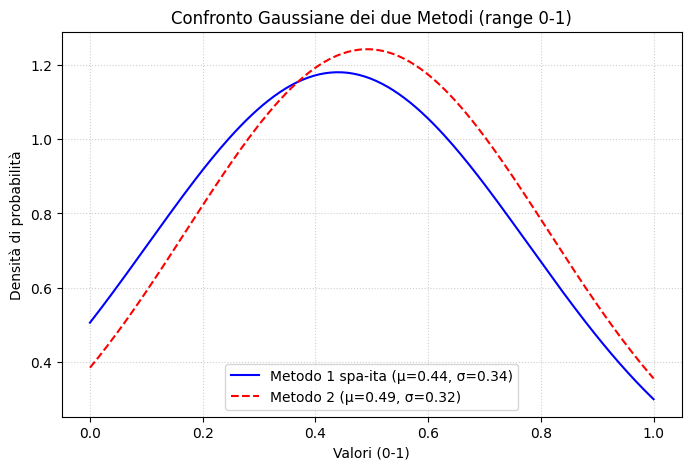

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_ambiguity_reduction(file_met1 = "/content/sample_data/pseudowords_table_method1.xlsx", file_met2 = "/content/sample_data/pseudowords_table_method2.xlsx"):
    met1 = pd.read_excel(file_met1)['ambiguity_score'].dropna().values
    met2 = pd.read_excel(file_met2)['ambiguity_score'].dropna().values

    # Calcolo media e deviazione standard
    mean1, std1 = np.mean(met1), np.std(met1)
    mean2, std2 = np.mean(met2), np.std(met2)

    # Range fisso da 0 a 1
    x = np.linspace(0, 1, 200)

    # Curve gaussiane
    y1 = norm.pdf(x, mean1, std1)
    y2 = norm.pdf(x, mean2, std2)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label=f"Metodo 1 spa-ita (μ={mean1:.2f}, σ={std1:.2f})", color="blue")
    plt.plot(x, y2, label=f"Metodo 2 (μ={mean2:.2f}, σ={std2:.2f})", color="red", linestyle="--")

    plt.title("Confronto Gaussiane dei due Metodi (range 0-1)")
    plt.xlabel("Valori (0-1)")
    plt.ylabel("Densità di probabilità")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.show()

plot_ambiguity_reduction()

## **Test dei vari metodi**

In [12]:
import time
def get_pseudowords_stats(method):

  resolutions = [100, 500, 1000, 3000, 5000, 7000, 10000]
  num_of_pairs_result_met1 = []
  num_of_pairs_result_met2 = []
  time_result_met1 = []
  time_result_met2 = []
  for res in resolutions:
    # met1 stats
    if(method == 1):
      dictionary_l1 = list(get_dictionary(language = "ita"))
      start_time = time.time()
      _, num_of_pairs = create_pseudoword_from_terms(dictionary_l1, res)
      end_time = time.time()
      time_result_met1.append(end_time - start_time)
      num_of_pairs_result_met1.append(num_of_pairs)

    # met2 stats
    if(method == 2):
      start_time = time.time()
      _, num_of_pairs = create_pseudoword_from_synset(res)
      end_time = time.time()
      time_result_met2.append(end_time - start_time)
      num_of_pairs_result_met2.append(num_of_pairs)

  if(method == 1):
    return time_result_met1, num_of_pairs_result_met1
  if(method == 2):
    return time_result_met2, num_of_pairs_result_met2







In [13]:
if __name__ == "__main__":
  dictionary_l1 = list(get_dictionary(language = "ita"))
  pseudoword_list, num_of_pairs = create_pseudoword_from_terms(dictionary_l1, 10000)
  print(f"Numero di coppie considerate metodo 1: {num_of_pairs}")
  plot_pseudowords_table(pseudoword_list, excel_filename="pseudowords_table_method1.xlsx")

  # Testing method 2
  pseudoword_list, num_of_pairs = create_pseudoword_from_synset(10000)
  print(f"Numero di coppie considerate metodo 2: {num_of_pairs}")
  plot_pseudowords_table(pseudoword_list, excel_filename="pseudowords_table_method2.xlsx")
  print("finish")
  """
    all_lemmas = set(lemma.name() for synset in wn.all_synsets() for lemma in synset.lemmas())
    print("Numero totale di lemmi:", len(all_lemmas))

    total_senses = sum(len(synset.lemmas()) for synset in wn.all_synsets())
    print("Numero totale di sensi:", total_senses)


    #Testing method 1
    dictionary_l1 = list(get_dictionary(language = "ita"))
    pseudoword_list, num_of_pairs = create_pseudoword_from_terms(dictionary_l1, 10000)
    print(f"Numero di coppie considerate metodo 1: {num_of_pairs}")
    plot_pseudowords_table(pseudoword_list, excel_filename="pseudowords_table_method1.xlsx")

    # Testing method 2
    pseudoword_list, num_of_pairs = create_pseudoword_from_synset(10000)
    print(f"Numero di coppie considerate metodo 2: {num_of_pairs}")
    plot_pseudowords_table(pseudoword_list, excel_filename="pseudowords_table_method2.xlsx")
    print("finish")


    time_result_met1, num_of_pairs_result_met1 = get_pseudowords_stats(1)
    time_result_met2, num_of_pairs_result_met2 = get_pseudowords_stats(2)
    plot_execution_times(time_result_met1, time_result_met2)
    plot_number_of_pairs(num_of_pairs_result_met1, num_of_pairs_result_met2)
    #test amiguity reduction
    word_ita = "banca"
    word_eng = "bank"
    reduction = compute_ambiguity_reduction(word_ita, word_eng)
    print(f"Ambiguity reduction between '{word_ita}' and '{word_eng}': {reduction:.4f}")
    spanish_dictionary = create_language_dictionary(language='spa')
    output_dir = "/home/patric/Documents/nltktest/TLN24-25/EserciziTerzaParte/ProgettoLab/Data"
    save_dictionary(output_dir, spanish_dictionary, 'spanish')

    italian_dictionary = create_language_dictionary(language='ita')
    english_dictionary = create_language_dictionary(language='eng')

    output_dir = "/home/patric/Documents/nltktest/TLN24-25/EserciziTerzaParte/ProgettoLab/Data"

    save_dictionary(output_dir, italian_dictionary, 'italian')
    save_dictionary(output_dir, english_dictionary, 'english')
    """

Numero di coppie considerate metodo 1: 28454


/tmp/ipython-input-1837833684.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_wrapped = df.applymap(lambda x: "\n".join(textwrap.wrap(str(x), width=30)))


Tabella salvata in:
 - Excel: /content/sample_data/pseudowords_table_method1.xlsx
Numero di coppie considerate metodo 2: 34646
Tabella salvata in:
 - Excel: /content/sample_data/pseudowords_table_method2.xlsx
finish
